# Approximating the Posterior

### Import statements

In [1]:
# Import everything you need
import math
import pandas as pd
import numpy as np
from numpy.random import binomial
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import multivariate_normal, gaussian_kde, norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Only needed for 3D plots, but unused
from matplotlib.mlab import bivariate_normal
from sklearn.preprocessing import normalize

# Prettier plots
import seaborn as sns
sns.set_style('darkgrid')

### Function definitions

In [43]:
# Simulate Bernoulli observations from Binomial dataset
def get_bernoulli(centered=False):
    """
    For each row in the dataset, corresponding to a Binomial observation, it will generate
    consistent Bernoulli trials making up that observation. This is then used by the likelihood function.
    The parameter "centered" is used to determine whether to use Dose or CenteredDose.
    """
    new = np.zeros((n, 2))  # a row for each Beetle
    for index, row in data.iterrows():
        obs = np.zeros(int(row.NumberExposed), dtype=int)
        obs[:int(row.NumberKilled)] = 1
        obs = obs.reshape(-1, 1)
        # Replace with row.CenteredDose if needed
        if centered:
            doses = np.repeat(row.CenteredDose, len(obs)).reshape(-1, 1)
        else:
            doses = np.repeat(row.Dose, len(obs)).reshape(-1, 1)
        obs = np.hstack((doses, obs))
        from_index = int(row.CumulativeN - row.NumberExposed)
        to_index = int(row.CumulativeN)
        new[from_index:to_index] = obs

    return pd.DataFrame(new, columns=['x', 'y'])

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Log-likelihood function
def log_likelihood(beta):
    """
    Log-likelihood function as shown in section 15.3 of Forster's book.
    """
    num = (y*np.dot(X, beta)).sum()
    den = np.log(np.exp(np.dot(X, beta)) + 1).sum()
    return num - den

def likelihood(beta):
    base = sigmoid(np.dot(X, beta))
    return ((base**y)*(1 - base**(1-y))).prod()

# Function used to plot a surface plot for a given function
def surface_plot(func, xleft, xright, yleft, yright, num):
    """
    Given a R2 -> R function "func" which takes an array of dimension 2 and returns a scalar, 
    this function will plot a surface plot over the specified region.
    """
    b1 = np.linspace(xleft, xright, num)
    b2 = np.linspace(yleft, yright, num)
    B1, B2 = np.meshgrid(b1, b2)
    Zbeta = np.array([func(beta) for beta in zip(B1.ravel(), B2.ravel())])
    Zbeta = Zbeta.reshape(B1.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(B1, B2, Zbeta)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    return B1, B2, Zbeta


def prepare_surface_plot(func, xleft, xright, yleft, yright, num):
    b1 = np.linspace(xleft, xright, num)
    b2 = np.linspace(yleft, yright, num)
    B1, B2 = np.meshgrid(b1, b2)
    Zbeta = np.array([func(beta) for beta in zip(B1.ravel(), B2.ravel())])
    Zbeta = Zbeta.reshape(B1.shape)
    return B1, B2, Zbeta

def plot_prepared_surface(X, Y, Z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z)
    return fig, ax
    
# Log-prior function
def log_prior(beta):
    """
    The log-prior is simply a normal distribution but terms not involving beta have been neglected.
    """
    return - np.dot(np.dot(X, beta).T, np.dot(X, beta)) / (8*n)

def prior(beta):
    return multivariate_normal.pdf(beta, mean=m0, cov=s0)

# Log-posterior function
def log_posterior(beta):
    """
    The log-posterior distribution is the sum of the log-likelihood and the log-prior due to 
    the stardad properties of logarithms.
    """
    return log_likelihood(beta) + log_prior(beta)

def posterior(beta):
    return likelihood(beta)*prior(beta)

# -log-posterior, this is used for our optimization routine in scipy
def minus_log_posterior(beta):
    """
    Simply the negative log-posterior.
    """
    return - log_posterior(beta)

# Metropolis algorithm for multivariate distributions
def metropolis_multivariate(p, z0=None, n_samples=100, burn_in=0, thinning=1, cov=None, n_params=2, centered=True):
    """
    Metropolis algorithm used to sample from a multivariate probability distribution.
    """
    z = z0 if z0 is not None else np.random.uniform(size=(n_params,))
    pz = p(z)
    # calculate total number of calculations
    tot = burn_in + (n_samples - 1) * thinning + 1
    # store the number of accepted samples to see acceptance rate
    accepted = 0
    # stores all the samples
    sample_list = np.zeros((tot, n_params))
    # Generate uniform random numbers outside the loop
    u = np.random.uniform(size=tot)
    # if covariance matrix is not provided, use default ones?
    if cov is None:
        if centered:
            cov = 5*np.array([[0.019, 0.127], [0.127, 8.48]])  # 5 has been found experimentally to have 25% acceptance
        else:
            cov = 4*np.array([[26.15, -14.69], [-14.69, 8.26]])
    normal_shift = multivariate_normal.rvs(mean=np.zeros(n_params), cov=cov, size=tot)

    for i in range(tot):
        # Sample a candidate from Normal(mu, sigma)
        cand = z + normal_shift[i]
        # Acceptance probability
        try:
            p_cand = p(cand)
            prob = min(0, p_cand - pz)  # Notice this is different from min(1, pcand / pz) as we are in logarithmic scale
        except (OverflowError, ValueError, RuntimeWarning):
            continue

        if prob > np.log(u[i]):  # Notice that this is log(u) because we are in logarithmic scale
            z = cand
            pz = p_cand  # to save computations
            accepted += 1

        sample_list[i, :] = z

    # Finally want to take every Mth sample in order to achieve independence
    print("Acceptance rate: ", accepted / tot)
    return sample_list[burn_in::thinning]

# Finds the variance matrix of
def laplace_vcov():
    """
    This function implements the variance-covariance matrix for the Laplace approximation. Notice that there 
    is a typo in Bishop's book because the variance-covariance matrix should be the inverse of Sn, which is
    why the last step here inverts the matrix.
    m0, s0: fixed hyperparameters. They are mean and vcov of prior distribution, which is multivariate normal.
    """
    first = np.linalg.inv(s0)
    y = sigmoid(np.dot(X, beta_map))
    # notice w^T phi_n is Phi w in matrix form
    outed = np.matmul(X[:, :, np.newaxis], X[:, np.newaxis, :])
    ystuff = (y*(1-y)).reshape(n, 1, 1)
    return np.linalg.inv(first + (ystuff * outed).sum(axis=0))

# Laplace approximation is just a normal distribution
def laplace_approx(beta):
    """
    Normal distribution approximating the posterior distribution for Laplace approximation.
    It is centered at the mode of the posterior beta_map, which is found with an optimization
    routine. It's variance covariance matrix is given by the function above "laplace_vcov".
    """
    return multivariate_normal.pdf(beta, mean=beta_map, cov=laplace_vcov())

def laplace_approx_log(beta):
        return np.log(multivariate_normal.pdf(beta, mean=beta_map, cov=laplace_vcov()))

def hessian(f, z0, h, k=None):
    """
    Finds Hessian matrix of function f:R^2-->R at the point z0 i.e. Hf(z)|_z=z0. The differencing 
    is done using step h on x, step k on y.
    Use:
    https://en.wikipedia.org/wiki/Finite_difference#Finite_difference_in_several_variables
    """
    k = h if k is None else k
    # Rename variables to be easier
    x = z0[0]  # first variable (beta_1)
    y = z0[1]  # second variable (beta_2)
    # Second derivative wrt x
    xup = np.array([x+h, y])
    still = np.array([x, y])
    xdown = np.array([x-h, y])
    yup = np.array([x, y+k])
    ydown = np.array([x, y-k])
    xupyup = np.array([x+h, y+k])
    xupydown = np.array([x+h, y-k])
    xdownyup = np.array([x-h, y+k])
    xdownydown = np.array([x - h, y - k])
    dxx = (f(xup) - 2*f(still) + f(xdown)) / h**2
    # Second derivative wrt y
    dyy = (f(yup) - 2*f(still) + f(ydown)) / k**2
    # Mixed derivatives
    dxy = (f(xupyup) - f(xupydown) - f(xdownyup) + f(xdownydown)) / (4*h*k)
    return np.array([[dxx, dxy], [dxy, dyy]])

def laplace_approx_numerical(beta):
    # find Sn
    #n = hessian(minus_log_posterior, z0=beta_map, h=0.01)
    return multivariate_normal.pdf(beta, mean=beta_map, cov=np.linalg.inv(H))


def var_sn_inverse(xi_vector):
    # reshape xi to do multiplication correctly
    xi_vector = xi_vector.reshape(n, 1, 1)
    lambda_xi = (sigmoid(xi_vector) - 0.5) / (2*xi_vector)
    # invert the prior vcov
    first = np.linalg.inv(s0)
    summed = 2*(lambda_xi*np.matmul(X[:, :, np.newaxis], X[:, np.newaxis, :])).sum(axis=0)
    return first + summed

def var_mn(xi_vector, sn=None):
    sn = np.linalg.inv(var_sn_inverse(xi_vector)) if sn is None else sn
    # find inverse prior vcov and multiply it by prior mean
    first = np.dot(np.linalg.inv(s0), m0)
    second = (X*(y.reshape(-1, 1)-0.5)).sum(axis=0)
    return np.dot(sn, first + second)    

def variational_normal(xi):
    """
    Variational method via EM-algorithm.
    """
    return multivariate_normal(mean=var_mn(xi), cov=np.linalg.inv(var_sn_inverse(xi))) 

def variational_em(tol=1e-5):
    # guess xi, one variational parameter for each data point
    xi = np.random.rand(n)
    xi_old = xi
    i = 0
    # store all
    history = np.ones((100, 2))
    # what stopping criteria to use?
    #while (not np.all(np.isclose(xi, xi_old, atol=tol))) or (i < 10):
    #while i < 100:
    while i < 100:
        xi_old = xi
        # find posterior over beta (latent). Actually we only need sn and mn?
        sn = np.linalg.inv(var_sn_inverse(xi))
        mn = var_mn(xi)
        history[i] = mn
        # now take only positive values of variational parameter
        half = np.dot(X, (sn + np.outer(mn, mn)))
        xi = np.sqrt(np.einsum('ij,ij->i',half, half))
        i += 1
    return xi, variational_normal(xi), history 

def variational_em_new(n_params):
    """
    This version optimizes each parameter in turn.
    """
    xi = np.random.rand(n)
    i = 0
    # store all
    history = np.ones((10, n_params))
    # what stopping criteria to use?
    #while (not np.all(np.isclose(xi, xi_old, atol=tol))) or (i < 10):
    #while i < 100:
    while i < 10:
        for index, xin in enumerate(xi):
            xn = X[index]
            # find posterior over beta (latent). Actually we only need sn and mn?
            sn = np.linalg.inv(var_sn_inverse(xi))
            mn = var_mn(xi)
            # now take only positive values of variational parameter
            xin = np.sqrt(np.dot(xn, np.dot((sn + np.outer(mn, mn)), xn)))
            xi[index] = xin
        history[i] = mn
        i += 1
    return xi, variational_normal(xi), history 

def variational_lower_bound(xi):
    """
    NEGATIVE VARIATIONAL LOWER BOUND. Because need to use minimize function.
    """
    # get mean and vcov
    sn_inv = var_sn_inverse(xi)
    sn = np.linalg.inv(sn_inv)
    mn = var_mn(xi)
    # lower bound terms
    first = 0.5*np.log(np.linalg.det(sn) / np.linalg.det(s0))
    second = 0.5*np.dot(mn, np.dot(sn_inv, mn))
    third = -0.5*np.dot(m0, np.dot(np.linalg.inv(s0), m0))
    fourth = (-0.5*xi + np.log(sigmoid(xi)) + ((sigmoid(xi) - 0.5) / (2*xi))*xi**2).sum()
    return -(first + second + third + fourth)

def variational_nr():
    opt_result = minimize(variational_lower_bound, np.ones(n))
    return opt_result.x

def kde_from_grid(func, n=200):
    # get grid data for log-laplace approx
    x, y, z = prepare_surface_plot(func, b1_left, b1_right, b2_left, b2_right, n)
    # make it an actual density
    z = z / z.sum()
    # now marginalize
    marginal_x = z.sum(axis=0)
    marginal_y = z.sum(axis=1)
    # linearly spaced points for the plots
    x_stuff = np.linspace(b1_left, b1_right, n)
    y_stuff = np.linspace(b2_left, b2_right, n)
    # resample both
    resample_x = np.random.choice(x_stuff, size=1000, p=marginal_x)
    resample_y = np.random.choice(y_stuff, size=1000, p=marginal_y)
    # KDE for both
    kde_x = gaussian_kde(resample_x)
    kde_y = gaussian_kde(resample_y)
    return kde_x, kde_y    

def simulate_bernoulli_dataset(dataset_size, params):
    """
    Simulates a Bernoulli dataset of size dataset_size. The parameters b0 and
    b1 are used to generate probabilities.
    
    params has to be a numpy array in order b0, b1, b2 ...
    """
    # number of parameters - 1  = number of explanatory variables
    nx = len(params) - 1
    # Create random normal(0, 1) for each explanatory variable
    X = np.random.normal(loc=0, scale=1, size=(dataset_size, nx))
    # add one initial column with 1s to use intercept parameter
    X = np.hstack((np.ones((dataset_size, 1)), X))
    # Linear combination
    linear_predictor = np.dot(X, params)
    # feed them into inverse logit function
    probability = np.exp(linear_predictor) / (1 + np.exp(linear_predictor))
    # now get bernoulli's rv with this probability
    binomial_samples = binomial(n=1, p=probability, size=dataset_size)
    # put data into dataframe and return it
    #return pd.DataFrame({'x':x, 'y':binomial_samples})
    return X, binomial_samples

def import_beetle_data(centered=True):
    """
    Ideally should be called with
    X, y = import_beetle_data(centered=True)
    """
    # Get data and create utility columns to facilitate bernoulli generation
    path = "D:\\Users\\Mauro\\Documents\\Main\\University\\" \
       "MATHS\\PROJECT\\variational_inference\\material _" \
       "from _forster\\BeetleMortality.csv"
    data = pd.read_csv(path, index_col=0)
    data.columns = ['Dose', 'NumberKilled', 'NumberExposed']
    data['CenteredDose'] = data.Dose.values - data.Dose.mean()
    data['CumulativeN'] = data.NumberExposed.cumsum()
    n = data.NumberExposed.sum()  # Number of Beetles

    # Create Bernoulli trials
    centered = True  # This is very important as it changes most calculations
    newdata = get_bernoulli(centered=centered)  # for centered "centered=True"

    # Create Design matrix and responses vector
    X = newdata.x.values.reshape(-1, 1)
    X = np.hstack((np.ones_like(X), X))
    y = newdata.y.values
    return X, y

def mcmc_timeseries_plot(n_params):
    # create figure and axis, one row per plot
    fig, ax = plt.subplots(nrows=n_params, ncols=1, figsize=(13, 3*n_params))
    for i in range(n_params):
        ax[i].plot(samples[:, i], 'k')
        ax[i].set_xlabel("Iteration", fontsize=12)
        ax[i].set_ylabel(r'$\beta_{{{}}}$'.format(i+1), fontsize=12)
    fig.suptitle(r"MCMC Time series plots", fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()
    
def mcmc_autocorrelation_plot(n_params):
    # See here: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
    fig, ax = plt.subplots(nrows=n_params, ncols=2, figsize=(15, 3*n_params))
    # Loop to do all autocorrelations
    for p in range(n_params):
        # Autocorrelation
        ax[p, 0].set_xlabel("Lags")
        ax[p, 0].set_ylabel("Correlation")
        _ = plot_acf(samples[:, p], ax=ax[p, 0], lags=30, title=r'$\beta_{{{}}}$ Autocorrelation'.format(p+1))
        # Partial autocorrelation
        ax[p, 1].set_xlabel("Lags")
        ax[p, 1].set_ylabel("Correlation")
        _ = plot_pacf(samples[:, p], ax=ax[p, 1], lags=30, title=r'$\beta_{{{}}}$ Partial Autocorrelation'.format(p+1))
    plt.tight_layout()
    plt.show()
        
def mcmc_kde_on_hist_plot(n_params, linspace_len=100):
    # Instantiate figure
    fig, ax = plt.subplots(n_params, figsize=(10, 4*n_params))
    # store all kdes to return them and use them later
    kdes = []
    # Loop to do all the plots
    for p in range(n_params):
        kde = gaussian_kde(samples[:, p].reshape(1, -1))
        kdes.append(kde)
        x_values = np.linspace(min(samples[:, p]), max(samples[:, p]), linspace_len)
        ax[p].hist(samples[:, p], bins=500, density=True, label=r'$p(\beta_{{{}}} \mid x)$'.format(p+1))
        ax[p].plot(x_values, kde.evaluate(x_values), label='kde')
        ax[p].legend()
    plt.show()
    return kdes
    
"""
IMPORTANT: These functions have been taken from:
https://stackoverflow.com/questions/28738836/matplotlib-with-odd-number-of-subplots
https://stackoverflow.com/a/53840947/6435921
"""
def choose_subplot_dimensions(k):
    if k < 4:
        return k, 1
    elif k < 11:
        return math.ceil(k/2), 2
    else:
        # I've chosen to have a maximum of 3 columns
        return math.ceil(k/3), 3


def generate_subplots(k, row_wise=False, suptitle=None, fontsize=20):
    nrows, ncols = choose_subplot_dimensions(k)
    # Choose your share X and share Y parameters as you wish:
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 5*nrows))
    figure.suptitle(suptitle, fontsize=fontsize)

    # Check if it's an array. If there's only one plot, it's just an Axes obj
    if not isinstance(axes, np.ndarray):
        return figure, [axes]
    else:
        # Choose the traversal you'd like: 'F' is col-wise, 'C' is row-wise
        axes = axes.flatten(order=('C' if row_wise else 'F'))

        # Delete any unused axes from the figure, so that they don't show
        # blank x- and y-axis lines
        for idx, ax in enumerate(axes[k:]):
            figure.delaxes(ax)

            # Turn ticks on for the last ax in each column, wherever it lands
            idx_to_turn_on_ticks = idx + k - ncols if row_wise else idx + k - 1
            for tk in axes[idx_to_turn_on_ticks].get_xticklabels():
                tk.set_visible(True)

        axes = axes[:k]
        return figure, axes

### Dataset import, preparation or creation

In [24]:
# Choose parameter values. This will also choose number of explanatory variables
#params = np.array([1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
params = np.insert(np.repeat(0.5, 9), 0, 1.0)
n, n_params = 200, len(params)x
# Simulate data
X, y = simulate_bernoulli_dataset(dataset_size=n, params=params)

### Finding posterior mode numerically

In [45]:
# Scipy "minimize" needs negative objective function to minimize
optimization_result = minimize(minus_log_posterior, np.zeros(n_params))
# grab the optimal solution
beta_map = optimization_result.x
# also grab the inverse of the hessian matrix. This can be used to approximate variance covariance matrix?
beta_vcov_opt = optimization_result.hess_inv
# A useful summary can be printed with "print(optimization_result)"
print("Posterior mode: [{}]".format(", ".join(["{:.3}".format(b) for b in beta_map])))
# this is not precise caus the likelihood has finitely many data points, so its modes wont be exactly at the theoretical levels

Posterior mode: [0.861, 0.158, 0.565, 0.402, 0.553, 0.211, 0.318, 0.538, 0.556, 0.607]


### MCMC Approximation

In [26]:
# Notice we don't need any burn-in because we are starting at the mode
# thinning for storage
samples = metropolis_multivariate(
    p=log_posterior, 
    z0=beta_map,
    n_samples=20000, 
    burn_in=10000,
    thinning=10,
    cov=1*beta_vcov_opt,   # should I multiply by 5?
    n_params=n_params
)

Acceptance rate:  0.16978822901933893


In [27]:
# Time series plots
#mcmc_timeseries_plot(n_params)

In [28]:
# Plot autocorrelation and partial autocorrelation
#mcmc_autocorrelation_plot(n_params)

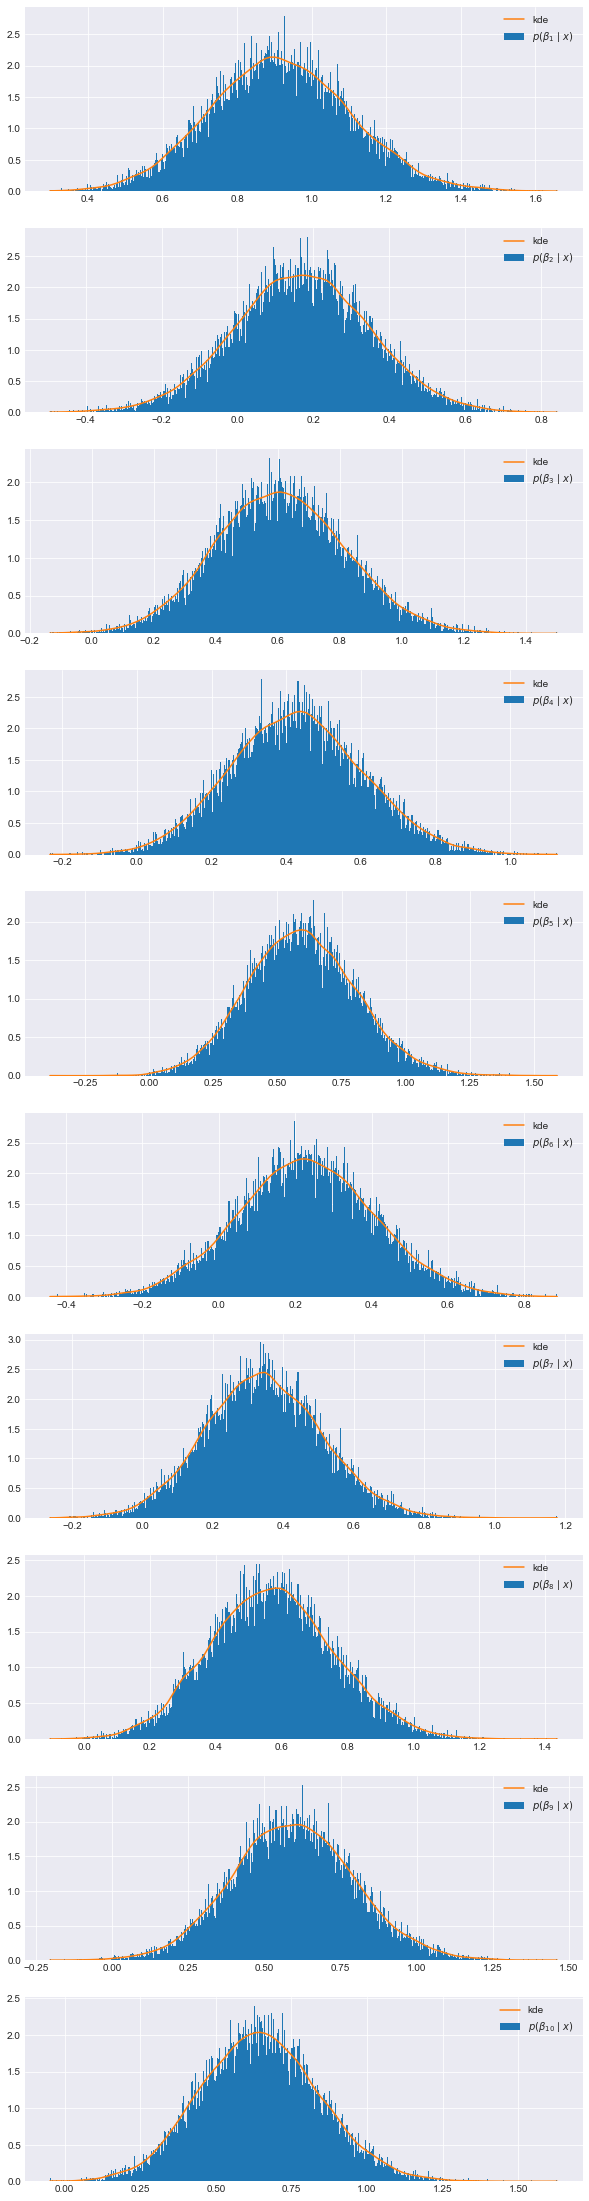

In [29]:
# plot marginal histograms of parameters and associated KDE
mcmc_kdes = mcmc_kde_on_hist_plot(n_params)

### Laplace Approximation

In [30]:
# Set up mean and vcov of normal prior
m0 = np.zeros(n_params)
s0 = 4*n*np.linalg.inv(np.dot(X.T, X))

# can only plot surface plot for 2 parameters
if n_params == 2:
    # Get data to plot
    Xlap, Ylap, Zlap = prepare_surface_plot(laplace_approx_log, b1_left, b1_right, b2_left, b2_right, 200)
    Xpos, Ypos, Zpos = prepare_surface_plot(log_posterior, b1_left, b1_right, b2_left, b2_right, 200)

    # Rescale data
    Zlap = Zlap - np.max(Zlap)
    Zpos = Zpos - np.max(Zpos)
    
    # Plot log-posterior and log-laplace in the same plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pos = ax.plot_surface(Xpos, Ypos, Zpos, label='log-posterior')
    lap = ax.plot_surface(Xlap, Ylap, Zlap, label='log-laplace')
    # legend for posterior
    pos._facecolors2d, lap._facecolors2d = pos._facecolors3d, lap._facecolors3d
    pos._edgecolors2d, lap._edgecolors2d = pos._edgecolors3d, lap._edgecolors3d
    ax.legend()
    plt.show()

In [31]:
if n_params == 2:
    # Plot contours together
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    ax[0].contour(Xlap, Ylap, Zlap)
    ax[0].set_title("Laplace Approximation")
    ax[1].contour(Xpos, Ypos, Zpos)
    ax[1].set_title("Log Posterior")
    plt.show()

### Variational Approximation

##### EM Algorithm and Analytical Integration

In [44]:
xi, variational_post, history = variational_em_new(n_params)

In [33]:
mn, sn = var_mn(xi), np.linalg.inv(var_sn_inverse(xi))
if n_params == 2:
    Xvar, Yvar, Zvar = prepare_surface_plot(variational_post.logpdf, b1_left, b1_right, b2_left, b2_right, 200)
    # rescale
    Zvar = Zvar - np.max(Zvar)
    # Plot log-posterior and log-laplace in the same plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    pos = ax.plot_surface(Xpos, Ypos, Zpos, label='log-posterior')
    lap = ax.plot_surface(Xlap, Ylap, Zlap, label='log-laplace')
    var = ax.plot_surface(Xvar, Yvar, Zvar, label='log-variational')
    # legend for posterior
    pos._facecolors2d, lap._facecolors2d, var._facecolors2d = pos._facecolors3d, lap._facecolors3d, var._facecolors3d
    pos._edgecolors2d, lap._edgecolors2d, var._edgecolors2d = pos._edgecolors3d, lap._edgecolors3d, var._edgecolors3d
    ax.legend()
    ax.set_xlabel(r'$\beta_1$')
    ax.set_ylabel(r'$\beta_2$')
    ax.set_title("Variational vs Laplace", fontsize=13)
    plt.show()

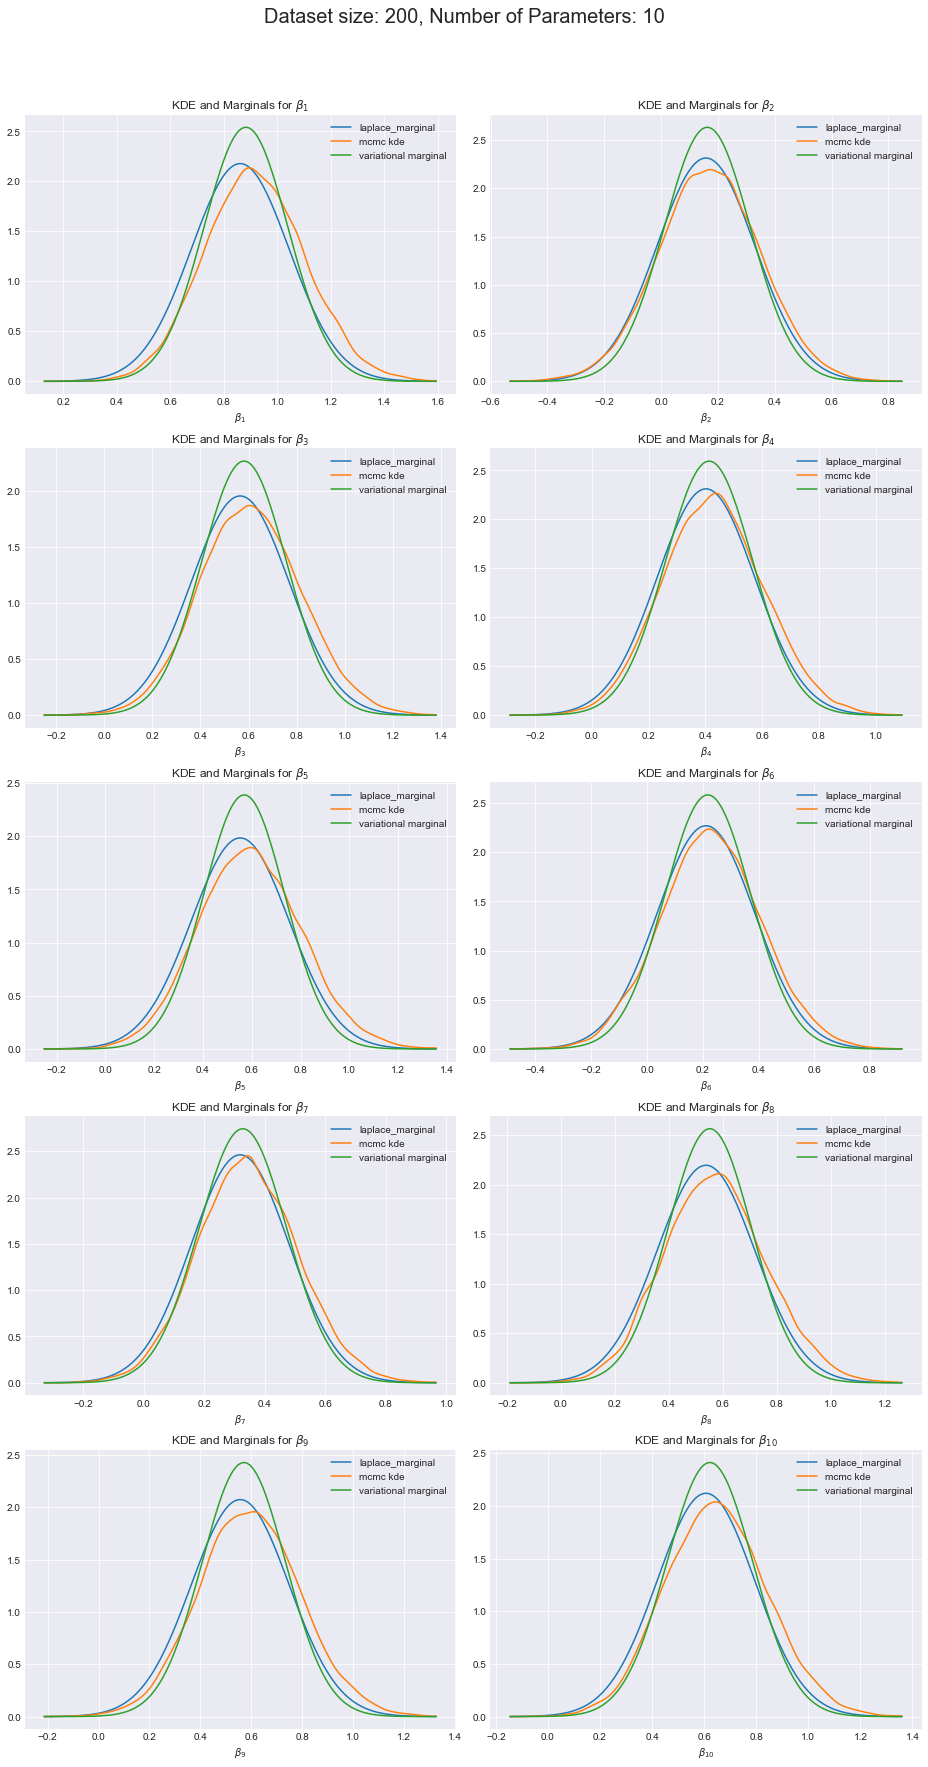

In [34]:
# find laplace marginals
laplace_vcov_matrix = laplace_vcov()
laplace_marginals = [norm(loc=beta_map[p],
                          scale=np.sqrt(laplace_vcov_matrix[p, p])) 
                     for p in range(n_params)]
# Find marginals distributions of variational normal using EM algorithm
var_marginals = [norm(loc=mn[p],
                      scale=np.sqrt(sn[p, p]))
                 for p in range(n_params)]
# plot everything
fig, axes = generate_subplots(n_params, row_wise=True, 
                              suptitle="Dataset size: {}, Number of Parameters: {}".format(n, n_params), 
                              fontsize=20)
for p, ax in zip(np.arange(n_params), axes):
    # obtain all marginals / kdes needed
    laplace, variational, mcmc = laplace_marginals[p], var_marginals[p], mcmc_kdes[p]
    # Use standard deviation to choose an x plotting range that makes the plot pretty
    max_std = max(laplace.std(), variational.std(), np.sqrt(mcmc.covariance[0, 0]))
    xmin = beta_map[p] - 4*max_std
    xmax = beta_map[p] + 4*max_std
    x_values = np.linspace(xmin, xmax, 200)
    # plot laplace, variational, mcmc
    ax.plot(x_values, laplace.pdf(x_values), label='laplace_marginal')
    ax.plot(x_values, mcmc.pdf(x_values), label='mcmc kde')
    ax.plot(x_values, variational.pdf(x_values), label='variational marginal')
    ax.set_xlabel(r'$\beta_{{{}}}$'.format(p+1))
    ax.legend()
    ax.set_title(r"KDE and Marginals for $\beta_{{{}}}$".format(p+1))
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

subsample the bernoulli's by 1/2 and so on. Laplace will get worse (func of size), what about variational?

Simulated dataset?

In [36]:
history[-1]

array([0.88266714, 0.16244458, 0.58135239, 0.41331456, 0.56906662,
       0.21811673, 0.32687689, 0.55195051, 0.57080285, 0.62198835])

In [37]:
history[-2]

array([0.88266161, 0.16244315, 0.58134792, 0.41331219, 0.56906123,
       0.21811443, 0.32687455, 0.55194641, 0.57079938, 0.6219846 ])